# **<font color=#ff7400> Dog Breeds Classification </font>**

## **<font color=#ff7400> A. Data Exploration </font>**

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

### **<font color=#ff7400> A.1 Images Visualization </font>**

We will start by loading some images to see what kind of pictures we are dealing with.

In [2]:
dogs_images_dir = "data/dog-breed-identification/train"
labels_csv_path = "data/dog-breed-identification/labels.csv"
labels = pd.read_csv(labels_csv_path)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
images = []
for i in range(3):  
    random_image = random.choice(os.listdir(dogs_images_dir))
    images.append(random_image)

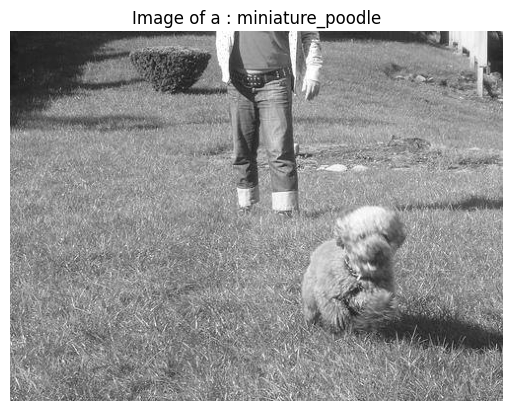

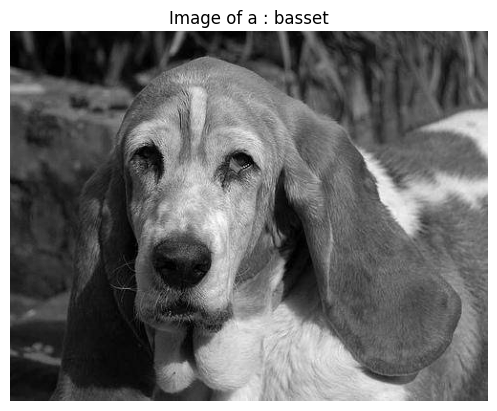

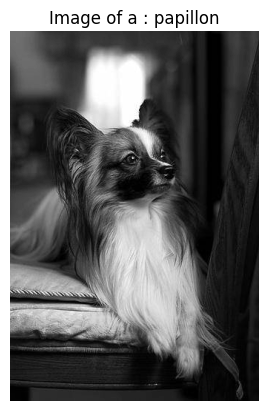

In [4]:
for image in images:
    dog_id = labels[labels["id"] == image[:-4]] # I am removing .jpg at end of file name
    for index, row in dog_id.iterrows():
        breed = row["breed"]
    full_image_path = os.path.join(dogs_images_dir, image)
    dog_img = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(dog_img, cmap="gray")
    plt.title(f"Image of a : {breed}")
    plt.axis('off')
    plt.show()

### **<font color=#ff7400> A.2 Images to arrays </font>**

Now, we will cast images into arrays so we can use them like we did before with the digits dataset.

In [5]:
from tqdm import tqdm

dog_image_arrays = []
dog_image_labels = []

for index, row in tqdm(labels.iterrows(), total=labels.shape[0]):
    image_id = row["id"]
    breed = row["breed"]
    full_image_path = os.path.join(dogs_images_dir, f"{image_id}.jpg")
    img = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_resized = cv2.resize(img, (128, 128))
        img_equalized = cv2.equalizeHist(img_resized)
        dog_image_arrays.append(img_equalized)
        dog_image_labels.append(breed)
    else:
        print(f"Failed to load image from {full_image_path}")


100%|██████████| 10222/10222 [00:05<00:00, 1873.45it/s]


In [6]:
image_arrays = np.array(dog_image_arrays)
image_labels = np.array(dog_image_labels)
dog_image_arrays[0]

array([[145,  87, 215, ..., 246, 235, 168],
       [ 62, 233, 210, ..., 194, 230, 221],
       [123, 113, 123, ..., 145, 182, 212],
       ...,
       [162, 158, 158, ..., 109, 100, 174],
       [155, 166, 166, ...,  58, 145, 226],
       [153, 168, 169, ...,  46,  52, 192]], dtype=uint8)

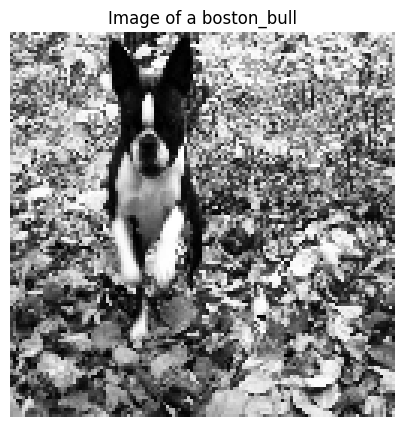

In [7]:
plt.figure(figsize=(8,5))
plt.imshow(image_arrays[0], cmap='gray')
plt.title(f'Image of a {image_labels[0]}')
plt.axis('off')
plt.show()

### **<font color=#ff7400> A.3 Check Balance of dataset </font>**

In [8]:
nb_classes = int(len(np.unique(image_labels)))

Text(0, 0.5, 'Occurences')

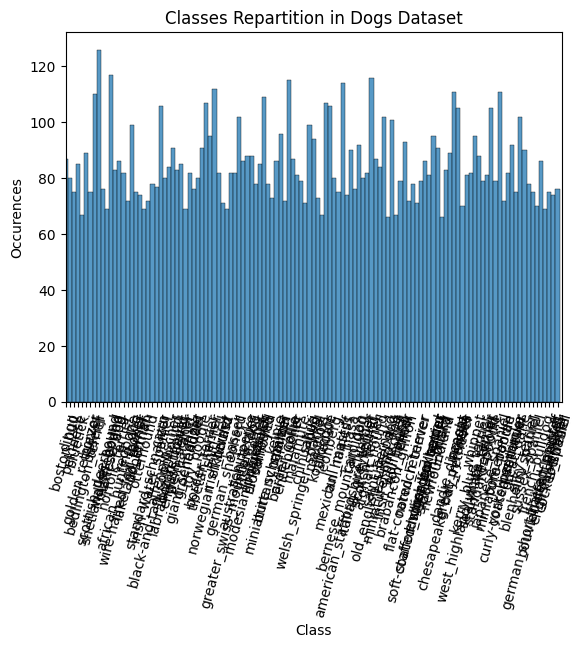

In [9]:
plt.plot()
sns.histplot(data=image_labels)
plt.title("Classes Repartition in Dogs Dataset")
plt.xlim(0,nb_classes)
plt.xlabel("Class")
plt.xticks(rotation=75)
plt.ylabel("Occurences")

As we can see, classes are imbalanced: some breeds have more pictures than others. In order to understand better which breeds are over/under-represented we can plot the top 10 for each:

In [10]:
class_count = labels["breed"].value_counts()
top_classes = class_count.nlargest(10).index
bottom_classes = class_count.nsmallest(10).index

top_class_data = labels[labels["breed"].isin(top_classes)]

bottom_class_data = labels[labels["breed"].isin(bottom_classes)]

/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_10363/3814410306.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=75)
/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_10363/3814410306.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=75)


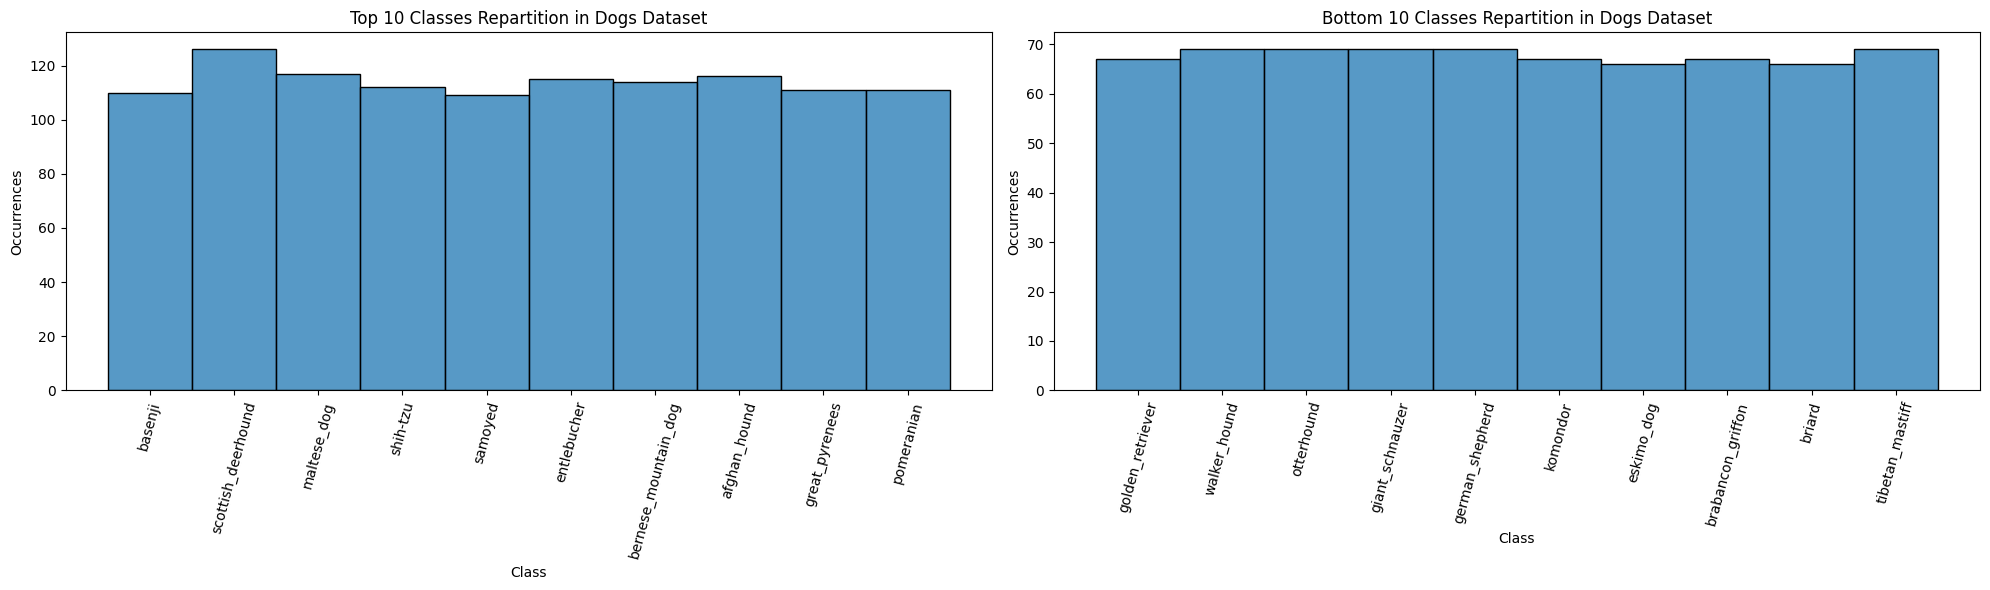

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# my top 10 classes
sns.histplot(data=top_class_data, x='breed', ax=axes[0])
axes[0].set_title("Top 10 Classes Repartition in Dogs Dataset")
axes[0].set_xlabel("Class")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=75)
axes[0].set_ylabel("Occurrences")

# my bottom 10 classes
sns.histplot(data=bottom_class_data, x='breed', ax=axes[1])
axes[1].set_title("Bottom 10 Classes Repartition in Dogs Dataset")
axes[1].set_xlabel("Class")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=75)
axes[1].set_ylabel("Occurrences")

plt.tight_layout()
plt.show()


### **<font color=#ff7400> B. Modelization </font>**

First, before building an ML model, we need to encode our labels. To do this, we will use the LabelEncoder from sklearn:

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

le = LabelEncoder()
le.fit(image_labels)
list(le.classes_)
third_label = list(le.classes_)[3]
encoded_labels = le.transform(image_labels)

In [13]:
print(third_label)
list(le.inverse_transform([3])) # checking it worked fine

airedale


['airedale']

In [14]:
num_samples, height, width = image_arrays.shape
X_flattened = image_arrays.reshape(num_samples, height * width)

X_train, y_train = X_flattened[:2000], encoded_labels[:2000] # training on first 2000 images only for computing perf
X_test, y_test = X_flattened[2000:3000], encoded_labels[2000:3000]

pipe_log_reg = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000))
pipe_log_reg.fit(X_train, y_train)
y_pred_train = pipe_log_reg.predict(X_train)

print("Here is the classification report for the train:")
print(classification_report(y_train, y_pred_train))

Here is the classification report for the train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        26
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        23
          15       1.00      1.00      1.00        15
          16       1.00      1.0

In [15]:
print(f"This is the accuracy for the train data: {pipe_log_reg.score(X_train, y_train)}")
print(f"This is the accuracy for the test data: {pipe_log_reg.score(X_test, y_test)}")

This is the accuracy for the train data: 0.9995
This is the accuracy for the test data: 0.028


As we can see we are overfitting, with the model failing to generalize: accuracy drops from 0.99 on the train to 0.028 for the test. It seems Logistic Regression is not suited for this kind of task. We can import our CNN model we built in the MNIST notebook to compare performance:

In [16]:
import sys
sys.path.append("./")
from cnn import model, plot_loss

In [17]:
X_train[0].shape

(16384,)

In [18]:
from sklearn.model_selection import train_test_split

def preprocessing(X,Y):
    num_samples, height, width = image_arrays.shape
    X_flattened = X.reshape(num_samples, height * width)
    square_root = int(np.sqrt(X_flattened.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = X_train_scaled.reshape(-1, square_root, square_root, 1)
    X_test_scaled = X_test_scaled.reshape(-1, square_root, square_root, 1)

    return X_train_scaled, X_test_scaled, y_train, y_test


In [19]:
X_train_scaled, X_test_scaled, y_train, y_test = preprocessing(image_arrays, encoded_labels)

In [20]:
tf_accuracy, tf_history = model(X_train_scaled[:1000], X_test_scaled[:1000], y_train[:1000], y_test[:1000], dropout_rate=0.0, nb_epochs=100)

Epoch 1/100


/Users/julien/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-05 15:24:42.535244: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-05 15:24:42.535263: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-05 15:24:42.535266: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-05 15:24:42.535281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-05 15:24:42.535292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0098 - loss: 5.7699 - val_accuracy: 0.0150 - val_loss: 4.7870
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0170 - loss: 4.7849 - val_accuracy: 0.0150 - val_loss: 4.7879
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0201 - loss: 4.7721 - val_accuracy: 0.0150 - val_loss: 4.7886
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0171 - loss: 4.7756 - val_accuracy: 0.0150 - val_loss: 4.7888
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0155 - loss: 4.7646 - val_accuracy: 0.0150 - val_loss: 4.7868
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0171 - loss: 4.7693 - val_accuracy: 0.0140 - val_loss: 4.7939
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0221 - loss: 4.7511 - val_accuracy: 0.0150 - val_loss: 4.7866
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0165 - loss: 4.7509 - val_accuracy: 0.0150 - val_l

In [21]:
print(f"Accuracy on Train and Test are respectively: {round(tf_history.history['accuracy'][-1], 3)}, {round(tf_accuracy[1], 3)}")

Accuracy on Train and Test are respectively: 0.05, 0.013


As we can see, with our original architecture, the model doesn't learn successfully enough the pattern of the images and our accuracy is very low on both train and test.

In order to try to improve the performance, I have reviewed the model function below and added more complexity to the model by adding:
- a third Convolution layer
- another hidden layer before the output layer
- added learning rate as a parameter to see impact on model performance

In [22]:
def model(X_train, X_test, y_train, y_test, dropout_rate=0.5, nb_epochs=50, lr=0.003):
    X_shape = X_train[0].shape
    nb_classes = len(np.unique(y_train))

    my_CNN = models.Sequential()
    my_CNN.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=X_shape))
    my_CNN.add(layers.Conv2D(64, (3, 3), activation="relu"))
    my_CNN.add(layers.MaxPooling2D((2, 2)))
    my_CNN.add(layers.Conv2D(128, (3, 3), activation="relu"))
    my_CNN.add(layers.MaxPooling2D((2, 2)))
    my_CNN.add(layers.Flatten())
    my_CNN.add(layers.Dense(512, activation="relu"))
    my_CNN.add(layers.Dropout(dropout_rate))
    my_CNN.add(layers.Dense(nb_classes, activation="softmax"))

    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    my_CNN.compile(optimizer=adam_optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    tf_history = my_CNN.fit(X_train, y_train, epochs=nb_epochs, validation_data=(X_test, y_test))
    tf_accuracy = my_CNN.evaluate(X_test,  y_test, verbose=2)

    return tf_accuracy, tf_history


In [23]:
tf_accuracy, tf_history = model(X_train_scaled[:5000], X_test_scaled[:5000], y_train[:5000], y_test[:5000], dropout_rate=0.0, nb_epochs=50)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.0108 - loss: 6.9880 - val_accuracy: 0.0091 - val_loss: 4.7848
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.0148 - loss: 4.7801 - val_accuracy: 0.0091 - val_loss: 4.7840
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.0082 - loss: 4.7774 - val_accuracy: 0.0091 - val_loss: 4.7840
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.0111 - loss: 4.7776 - val_accuracy: 0.0091 - val_loss: 4.7849
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.0123 - loss: 4.7769 - val_accuracy: 0.0111 - val_loss: 4.7841
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.0094 - loss: 4.7735 - val_accuracy: 0.0091 - val_loss: 4.7847
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.0116 - loss: 4.7732 - val_accuracy: 0.0091 - val_loss: 4.7846
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.0131 - loss: 4

Unfortunately, performances did not improved. I also observed that it took ~ 20mins to compute the gradients for 50 epochs only.

Therefore, I decided to implement below a pre-trained algorithm from Tensorflow. I picked the ResNet50 algorithm as on the Keras.io [documentation](https://keras.io/api/applications/#usage-examples-for-image-classification-models).

I have frozen the base of the model to use weights from pre-training and added a GlobalAveragePooling2D as I have seen in the [documentation](https://keras.io/api/layers/pooling_layers/average_pooling2d/) it improves performance as it will reduce the dimension of the features before being passed to the next layer. As well, as per the documentation of [ResNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) the inputs need to be processed in a very specific way for which the model was designed, so I have used the [preprocess_input function](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input).

By doing so, my accuracy went up but I still noticed overfitting. Therefore, I followed the tutorial for Data Augmentation from Tensorflow (available [here](https://www.tensorflow.org/tutorials/images/classification#overfitting)) and added custom parameters to the model so I can play with the rotation and zoom ratio if needed.

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import models, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def resnet_model(X_train, X_test, y_train, y_test, nb_classes, rotation_ratio=0.1, zoom_ratio=0.1, dropout_rate=0.5, nb_epochs=50):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base_model.trainable = False
    
    data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                        input_shape=(128,
                                    128,
                                    3)),
        layers.RandomRotation(rotation_ratio),
        layers.RandomZoom(zoom_ratio),
    ]
    )

    my_CNN = models.Sequential([data_augmentation])
    my_CNN.add(base_model)
    my_CNN.add(GlobalAveragePooling2D())
    my_CNN.add(layers.Dense(256, activation='relu'))
    my_CNN.add(layers.Dropout(dropout_rate))
    my_CNN.add(layers.Dense(nb_classes, activation='softmax'))

    my_CNN.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

    tf_history = my_CNN.fit(X_train, y_train, epochs=nb_epochs,
                            validation_data=(X_test, y_test))
    tf_accuracy = my_CNN.evaluate(X_test, y_test, verbose=2)

    return tf_accuracy, tf_history

In [40]:
# recreating arrays by opening images in RGB format so it can be preprocessed and fitted properly by VGG16
from tqdm import tqdm

dogs_images_dir = "data/dog-breed-identification/train"
labels_csv_path = "data/dog-breed-identification/labels.csv"
labels = pd.read_csv(labels_csv_path)

dog_image_arrays = []
dog_image_labels = []

for index, row in tqdm(labels.iterrows(), total=labels.shape[0]):
    image_id = row["id"]
    breed = row["breed"]
    full_image_path = os.path.join(dogs_images_dir, f"{image_id}.jpg")
    img = cv2.imread(full_image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img_resized = cv2.resize(img, (128, 128))
        dog_image_arrays.append(img_resized)
        dog_image_labels.append(breed)
    else:
        print(f"Failed to load image from {full_image_path}")

dog_image_arrays = np.array(dog_image_arrays)
dog_image_labels = np.array(dog_image_labels)

dog_image_arrays = preprocess_input(dog_image_arrays)

100%|██████████| 10222/10222 [00:06<00:00, 1558.44it/s]


In [41]:
le = LabelEncoder()
le.fit(dog_image_labels)
encoded_labels = le.transform(dog_image_labels)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(dog_image_arrays, encoded_labels, test_size=0.3, random_state=42)

In [44]:
number_classes = int(len(np.unique(encoded_labels)))
tf_accuracy, tf_history = resnet_model(X_train, X_test, y_train, y_test, nb_classes=number_classes, dropout_rate=0.1, nb_epochs=50)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - accuracy: 0.0879 - loss: 4.5066 - val_accuracy: 0.2687 - val_loss: 2.9228
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.2711 - loss: 2.9654 - val_accuracy: 0.3469 - val_loss: 2.5584
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.3650 - loss: 2.5036 - val_accuracy: 0.3603 - val_loss: 2.5026
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.3959 - loss: 2.3050 - val_accuracy: 0.3795 - val_loss: 2.4374
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.4421 - loss: 2.0889 - val_accuracy: 0.3818 - val_loss: 2.4419
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.4695 - loss: 1.9721 - val_accuracy: 0.3867 - val_loss: 2.4001
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.5015 - loss: 1.8531 - val_accuracy: 0.3870 - val_loss: 2.5228
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.5090 - loss: 1.7969 -

In [45]:
tf_accuracy

[3.915163040161133, 0.3945223391056061]

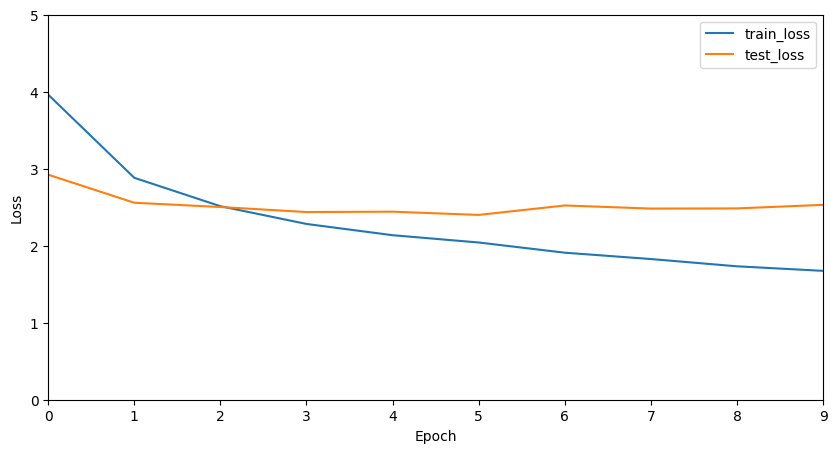

In [46]:
epochs = range(10)

plt.figure(figsize=(10,5))
plt.plot(tf_history.history["loss"], label="train_loss")
plt.plot(tf_history.history["val_loss"], label = "test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.xlim([0, int(max(epochs))])
plt.ylim([0, 5])
plt.legend(loc="upper right")
plt.show()